# SCEPS Scene

In [1]:
import os 
import sys
import numpy as np
import xarray as xr
import pyresample as pr
import importlib
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from cartopy import crs as ccrs
import cmcrameri.cm as cmc

# local imports
if '/tools/' not in sys.path:
    sys.path.insert(0, os.path.abspath('../.../') + 'algorithm/tools/')
import l2_format as l2
import TSA_algorithm as algorithm
import l2_tools as tools

In [2]:
# reload local imports
importlib.reload(l2)
importlib.reload(algorithm)
importlib.reload(tools)

<module 'l2_tools' from 'c:\\Users\\zschende\\OneDrive - Ilmatieteen laitos\\Files\\Projects\\CIMR Devalgo\\ATBD\\TerrestrialSnowArea_ATBD_v2\\algorithm/tools\\l2_tools.py'>

In [3]:
l2_grid = 'testcard_ease2_1km'
area_def = pr.load_area('testcard_adef.yaml',l2_grid)

cart_crs = area_def.to_cartopy_crs()
# extent = cart_crs.bounds
trg_lon, trg_lat = area_def.get_lonlats()

In [4]:
l1x = os.path.abspath('../../../..../') + 'Data/SCEPS/SCEPS_l1x@KA_sceps_geo_polar_scene_1_unfiltered_tot_minimal_nom_nedt_apc_tot_v2p1.nc'

# l1b_path = l1x      # os.path.basename(l1b_path) for netcdf
data_fwd,geo_fwd,data_bck,geo_bck = tools.read_l1x(l1x)

surface_file = os.path.abspath('../../../..../') + 'Data/SCEPS/cimr_sceps_geo_card_devalgo_polarscene_1_20161217_harmonised_v2p0_surface.nc'
surface = xr.open_dataset(surface_file)

algo = 'Pulliainen2010'
algo_version = '0.9.0'

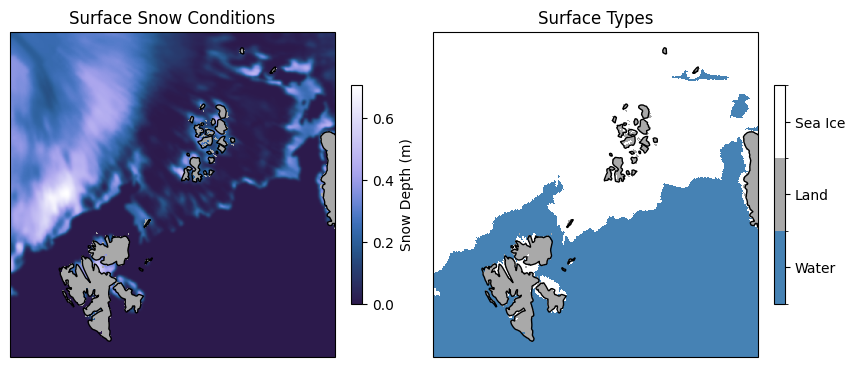

In [5]:
cart_crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,10),
                       subplot_kw=dict(projection=cart_crs))

cmap = cmc.devon
cmap.set_bad(color='darkgrey')

img = ax[0].pcolormesh(surface['longitude'].values[0,:,:], surface['latitude'].values[0,:,:], surface['snow_thickness'].values[0,:,:], transform=ccrs.PlateCarree(), cmap=cmap)
ax[0].coastlines(color='black')
ax[0].set_title('Surface Snow Conditions')
cbar = plt.colorbar(img, cmap=cmap, fraction=0.031, pad=0.046)
cbar.set_label('Snow Depth (m)')

cmap = colors.ListedColormap(['steelblue', 'darkgrey', 'white'])
vrange=[0.5,1.5,2.5,9.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

img = ax[1].pcolormesh(surface['longitude'].values[0,:,:], surface['latitude'].values[0,:,:], surface['land_sea_ice_mask'].values[0,:,:], transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax[1].coastlines(color='black')
ax[1].set_title('Surface Types')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[1,2,6], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['Water', 'Land', 'Sea Ice'])
    
plt.show()

In [6]:
TSA_fwd = algorithm.dry_snow_detection(data_fwd,tsa_algorithm=algo)
TSA_bck = algorithm.dry_snow_detection(data_bck,tsa_algorithm=algo)

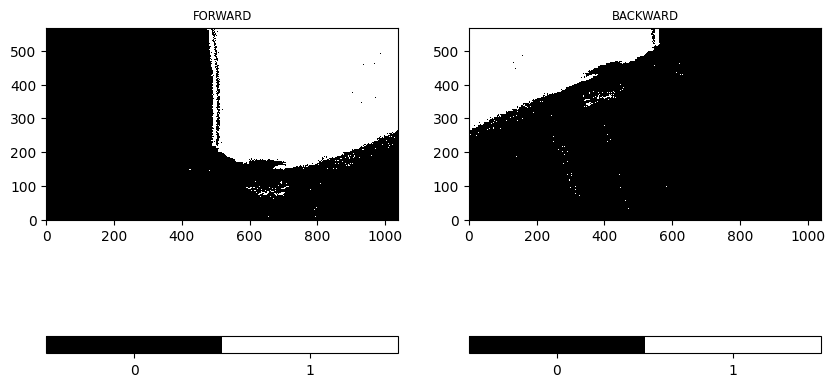

In [7]:
cmap = colors.ListedColormap(['black', 'white'])
vrange=[0,.5,1]
# cmap.set_bad(color='red')

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,10))

img = ax[0].imshow(TSA_fwd, vmin=0, vmax=1, interpolation='none', origin='lower', cmap=cmap)
ax[0].set_title('FORWARD', fontsize='small')
# plt.text(0.01,0.99,'TSA',va='top',color='white')
cbar = plt.colorbar(img, boundaries=vrange, ticks=[0.25, 0.75], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '1'])

img = ax[1].imshow(TSA_bck, vmin=0, vmax=1, interpolation='none', origin='lower', cmap=cmap)
ax[1].set_title('BACKWARD', fontsize='small')
# plt.text(0.01,0.99,'TSA',va='top',color='white')
cbar = plt.colorbar(img, boundaries=vrange, ticks=[0.25, 0.75], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '1'])
    
# fig.savefig('tsa_swath.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

In [8]:
TSA_fwd_proj = tools.reproject_to_grid(TSA_fwd,geo_fwd,area_def=area_def)
TSA_bck_proj = tools.reproject_to_grid(TSA_bck,geo_bck,area_def=area_def)

In [9]:
# intermediate combined data
TSA_comb, TSA_comb_uncert = tools.combine_proj(TSA_fwd_proj,TSA_bck_proj)

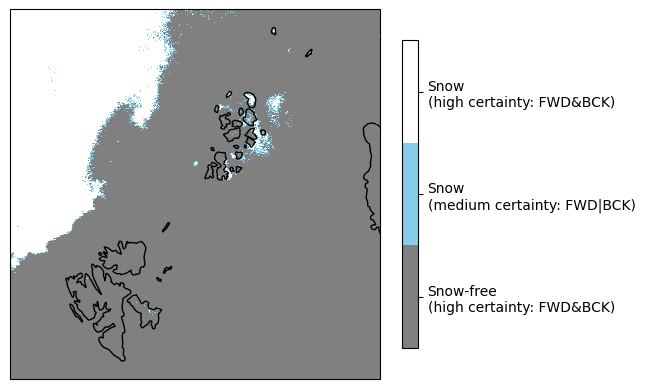

In [10]:
cmap = colors.ListedColormap(['grey', 'skyblue', 'white'])
vrange=[-0.25,0.25,0.75,1.25]
norm = colors.BoundaryNorm(vrange, cmap.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(trg_lon, trg_lat, TSA_comb_uncert, transform=ccrs.PlateCarree(), cmap=cmap)
# ax.set_title('Radiometric Test Card Evaluation')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,0.5,1], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['Snow-free\n(high certainty: FWD&BCK)', 'Snow\n(medium certainty: FWD|BCK)', 'Snow\n(high certainty: FWD&BCK)'])
ax.coastlines()
# plt.gcf().set_size_inches((20,20))

# plt.savefig('tsa_uncert_sceps.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

Visualization of brightness temperature conditions:

In [11]:
TB_KUh_fwdproj = tools.reproject_to_grid(data_fwd['KU'].brightness_temperature_h.values,geo_fwd,area_def=area_def)
TB_KAh_fwdproj = tools.reproject_to_grid(data_fwd['KA'].brightness_temperature_h.values,geo_fwd,area_def=area_def)
TB_KAv_fwdproj = tools.reproject_to_grid(data_fwd['KA'].brightness_temperature_v.values,geo_fwd,area_def=area_def)

TB_KUh_bckproj = tools.reproject_to_grid(data_bck['KU'].brightness_temperature_h.values,geo_bck,area_def=area_def)
TB_KAh_bckproj = tools.reproject_to_grid(data_bck['KA'].brightness_temperature_h.values,geo_bck,area_def=area_def)
TB_KAv_bckproj = tools.reproject_to_grid(data_bck['KA'].brightness_temperature_v.values,geo_bck,area_def=area_def)

In [12]:
diff_h_fwdproj = TB_KUh_fwdproj-TB_KAh_fwdproj
diff_h_fwdproj[diff_h_fwdproj < 0] = 0

diff_h_bckproj = TB_KUh_bckproj-TB_KAh_bckproj
diff_h_bckproj[diff_h_bckproj < 0] = 0

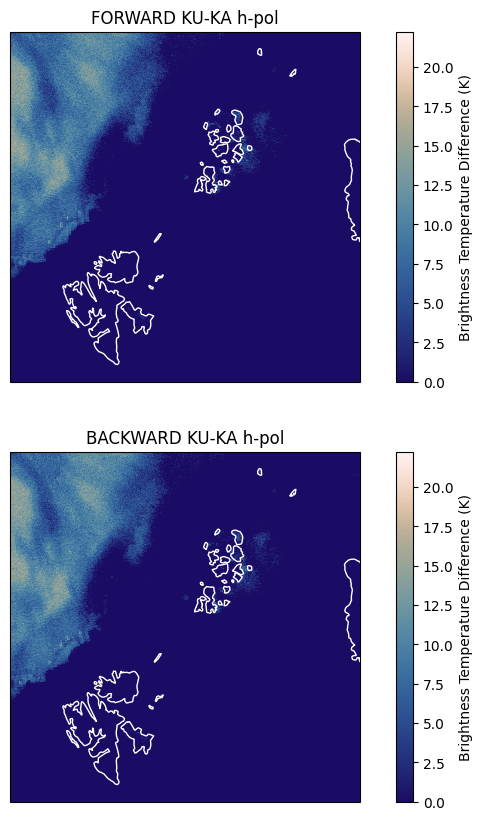

In [13]:
cmap = cmc.lapaz
norm = mpl.colors.Normalize(vmin = np.nanmin(0), vmax = np.nanmax([diff_h_fwdproj, diff_h_bckproj])) 

cart_crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,10),
                       subplot_kw=dict(projection=cart_crs))

img = ax[0].pcolormesh(trg_lon, trg_lat, diff_h_fwdproj, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax[0].coastlines(color='white')
ax[0].set_title('FORWARD KU-KA h-pol')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, fraction=0.031, pad=0.046)
cbar.set_label('Brightness Temperature Difference (K)')

img = ax[1].pcolormesh(trg_lon, trg_lat, diff_h_bckproj, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax[1].coastlines(color='white')
ax[1].set_title('BACKWARD KU-KA h-pol')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, fraction=0.031, pad=0.046)
cbar.set_label('Brightness Temperature Difference (K)')
    
plt.show()
